# Learning more general warp metrics
Instead of fitting to aspects of the [Alcubierre metric](https://arxiv.org/pdf/gr-qc/0009013), let's choose more open-ended loss terms and see if we can find alternative solutions.

[Analyzing Warp Drive Spacetimes with Warp
Factory](https://arxiv.org/abs/2404.03095) proposes three core features of a warp drive.

<blockquote>

The field of warp mechanics does not have a unified definition of what is required by
a warp solution. However, there are several aspects that emerge as important features
of any solution. A warp drive aims to provide a controlled and comfortable journey
through space. This goal motivates the three core features of a warp drive: geodesic
transport, a flat passenger region, and a spatially compact and comoving warp bubble.

(i) Geodesic transport. Warp drives should transport passengers from point A to point
B along a geodesic trajectory. This means the passengers inside the warp drive
do not experience local acceleration while being transported.
For a non-trivial solution, the passengers should not ‘already be going to’ point B. One possible scenario is that passengers start at rest (relative to points A and B) at point A, are transported to point B, and are then, again, at rest relative to both points.
Additionally, this transport should occur for a limited region in spacetime.

(ii) Empty passenger region. There should exist a defined passenger volume that is
both vacuum (T_µν = 0) and free from large tidal forces.

(iii) A spatially bounded, comoving bubble. The stress-energy required for the geodesic
transport should not extend to infinity8
. The stress-energy of the bubble also needs
to move along with the transported observers. The requirement of it comoving with
passengers distinguishes warp drive solutions from Krasnikov tubes 
</blockquote>

We'll look at recasting these as loss terms for the optimization of our model.

In [68]:
# Install stuff if we're in colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install dm-haiku

In [69]:
from functools import partial

import jax
import jax.numpy as jnp
import haiku as hk
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

#from jax.config import config
jax.config.update("jax_debug_nans", True)

I found all of the basic building blocks for modeling relativity in JAX here: https://github.com/haimengzhao/relativity-jax

In [70]:
# Start from https://github.com/haimengzhao/relativity-jax

metric = lambda coords, model: model(coords)

pd_metric = jax.jacfwd(metric)

def christoffel(coords, model):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)
    partial_derivs = jnp.einsum('mns -> smn', pd_metric(coords, model))
    sum_partial_derivs = partial_derivs + jnp.einsum('nrm -> mnr', partial_derivs) - jnp.einsum('rmn -> mnr', partial_derivs)
    christ = 0.5 * jnp.einsum('sr, mnr -> smn', inv_met, sum_partial_derivs)
    return christ
pd_christoffel = jax.jacfwd(christoffel)


def riemann_curvature(coords, model):
    christ = christoffel(coords, model)
    pd_christ = jnp.einsum('rmns -> srmn', pd_christoffel(coords, model))
    return jnp.einsum('mrns -> rsmn', pd_christ) - jnp.einsum('nrms -> rsmn', pd_christ) + jnp.einsum('rml, lns -> rsmn', christ, christ) - jnp.einsum('rnl, lms -> rsmn', christ, christ)


def ricci_tensor(coords, model):
    riemann = riemann_curvature(coords, model)
    return jnp.einsum('rsru -> su', riemann)


def ricci_scalar(coords, model):
    return jnp.einsum('mn, mn -> ', jnp.linalg.inv(metric(coords, model)), ricci_tensor(coords, model))


def einstein_tensor(coords, model):
    met = metric(coords, model)
    ricci_ts = ricci_tensor(coords, model)
    return ricci_ts - 0.5 * jnp.einsum('mn, mn -> ', jnp.linalg.inv(met), ricci_ts).reshape(1, 1) * met

# End https://github.com/haimengzhao/relativity-jax


Here are some primitives we'll need later.

In [71]:
def stress_energy_tensor(model, coords):
    G = einstein_tensor(coords, model)
    T = G / (jnp.pi * 8)
    return T

def energy_density(model, coords):
    return stress_energy_tensor(model, coords)[0, 0]

# Velocity field
def velocity_field(coords):
    u = jnp.zeros_like(coords)
    u = u.at[0].set(1.0)  # u^t = 1, u^i = 0 for i = 1, 2, 3
    return u

# Covariant derivative of the velocity field
def covariant_derivative_u(model, coords):
    u = velocity_field(coords)
    christ = christoffel(coords, model)
    return jax.jacfwd(lambda x: u)(coords) - jnp.einsum('ijk,j->ik', christ, u)

# Shear tensor
def shear_tensor(model, coords):
    cov_deriv_u = covariant_derivative_u(model, coords)
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)

    # Symmetric part of the covariant derivative
    symmetric_part = 0.5 * (cov_deriv_u + jnp.einsum('ij->ji', cov_deriv_u))
    # Remove trace part to get the shear tensor
    trace_part = (1.0 / 3.0) * jnp.einsum('ij,ij->', inv_met, symmetric_part) * met
    shear = symmetric_part - trace_part
    return shear

# Shear scalar
def shear_scalar(model, coords):
    shear = shear_tensor(model, coords)
    return jnp.sqrt(0.5 * jnp.einsum('ij,ij', shear, shear))

# Vorticity tensor
def vorticity_tensor(model, coords):
    cov_deriv_u = covariant_derivative_u(model, coords)
    # Antisymmetric part of the covariant derivative
    antisymmetric_part = 0.5 * (cov_deriv_u - jnp.einsum('ij->ji', cov_deriv_u))
    return antisymmetric_part

# Vorticity scalar
def vorticity_scalar(model, coords):
    vorticity = vorticity_tensor(model, coords)
    return jnp.sqrt(0.5 * jnp.einsum('ij,ij', vorticity, vorticity))

# Expansion scalar
def expansion_scalar(model, coords):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)

    pd_met = pd_metric(coords, model)
    trace_extrinsic_curvature = jnp.einsum('mnm -> n', pd_met)

    theta = jnp.einsum('mn, n -> ', inv_met, trace_extrinsic_curvature)
    return theta

The Alcubierre metric. We'll keep it around for comparison to models we discover.

In [117]:
# Alcubierre metric parameters
v_s = 0.5  # Warp bubble velocity
sigma = 3  # Steepness of the bubble's edge
R = 2  # Radius of the bubble

def alcubierre_metric(coords):
    t, x, y, z = coords
    r_s = jnp.sqrt((x - v_s * t)**2 + y**2 + z**2)
    f_rs = (jnp.tanh(sigma * (r_s + R)) - jnp.tanh(sigma * (r_s - R))) / (2 * jnp.tanh(sigma * R))

    v2 = v_s**2
    f2 = f_rs**2

    g = jnp.array([
        [-1 + v2 * f2, -v_s * f2, 0, 0],
        [-v_s * f2, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return g

def alcubierre_metric_comoving(coords):
    t, x_prime, y, z = coords
    r_s = jnp.sqrt(x_prime**2 + y**2 + z**2)
    f_rs = (jnp.tanh(sigma * (r_s + R)) - jnp.tanh(sigma * (r_s - R))) / (2 * jnp.tanh(sigma * R))
    f2 = f_rs**2

    g_tt = -1 + v_s**2 * (1 - f2)
    g_tx = v_s * (1 - f2)

    g = jnp.array([
        [g_tt, g_tx, 0, 0],
        [g_tx, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return g

Just need some plotting code and then it's warping time.

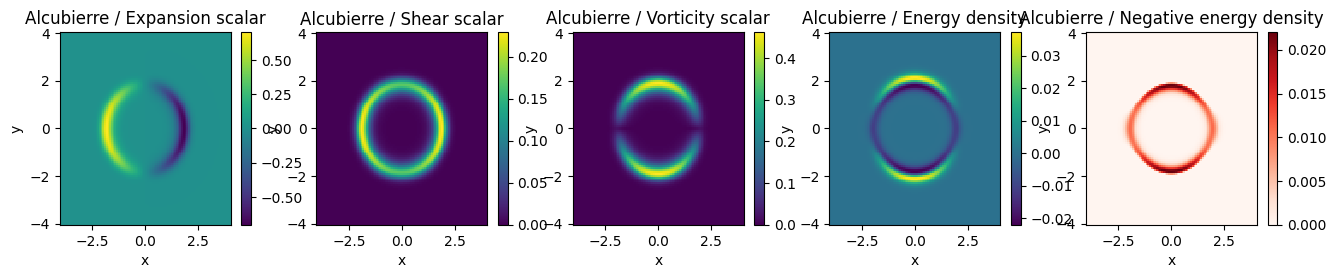

In [127]:
# Mostly generated by chatgpt, thanks
def plot_scalar_field(scalar_field, title='Scalar', color_label=None, w=3, n=100, quantile=None, cmap='viridis', shading='auto', **kwargs):
    # Generate grid points for the plot
    x_values = jnp.linspace(-w, w, n)
    y_values = jnp.linspace(-w, w, n)

    # Create mesh grids for the coordinates
    X, Y = jnp.meshgrid(y_values, x_values, indexing='ij')

    # Expand dimensions for broadcasting
    Y_flat = Y.flatten()
    X_flat = X.flatten()
    Z_flat = jnp.zeros_like(X_flat)  # z = 0 for all points
    T_flat = jnp.zeros_like(X_flat)  # t = 0 for all points
    # Combine into a single array of coordinates
    coords_flat = jnp.stack([T_flat, X_flat, Y_flat, Z_flat], axis=-1)
    # Compute the expansion scalar over the entire grid using vectorized function
    values_flat = scalar_field(coords_flat)
    values_flat = values_flat.at[jnp.isnan(values_flat)].set(0)
    # Clamp extreme values:
    if quantile is not None:
        qs = jnp.quantile(jnp.abs(values_flat), quantile)
        values_flat = values_flat.clip(-qs, qs)

    # Reshape back to match the grid shape
    values = jnp.reshape(values_flat, X.shape)
    # Plot the expansion scalar
    plt.pcolormesh(X, Y, values, cmap=cmap, shading=shading, **kwargs)
    plt.colorbar(label=color_label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    return values, X, Y

def plot_scalars(values, X, Y, title='Scalar', color_label=None, cmap='viridis', shading='auto', **kwargs):
    # Plot the expansion scalar
    plt.pcolormesh(X, Y, values, cmap=cmap, shading=shading, **kwargs)
    plt.colorbar(label=color_label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

def plot_warp_scalars(f_metric, title, **plot_kwargs):
    plt.figure(figsize=(16, 3))
    for i, (f_scalar, subtitle) in enumerate((
        (expansion_scalar, 'Expansion scalar'),
        (shear_scalar, 'Shear scalar'),
        (vorticity_scalar, 'Vorticity scalar'),
    )):
        plt.subplot(1, 3, i + 1)
        vectorized_scalar = jax.vmap(partial(f_scalar, f_metric), in_axes=(0,))
        subtitle = f'{title} / {subtitle}'
        plot_scalar_field(vectorized_scalar, title=subtitle, **plot_kwargs)

def plot_energy(f_metric, title='', w=3, n=100, quantile=None):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    vectorized_energy_density = jax.jit(jax.vmap(partial(energy_density, f_metric), in_axes=(0,)))
    values, X, Y = plot_scalar_field(vectorized_energy_density, title=title + ' / Energy density', w=w, n=n, quantile=quantile)
    plt.subplot(1, 2, 2)
    plot_scalars(-values.clip(None, 0), X, Y, title=title + ' / Negative energy density', cmap='Reds')

def make_plots(f_metric, title='', w=2, n=100, quantile=None):
    plot_kwargs = dict(w=w, n=n, quantile=quantile)
    plt.figure(figsize=(16, 2.5))
    # warp scalars
    for i, (f_scalar, subtitle) in enumerate((
        (expansion_scalar, 'Expansion scalar'),
        (shear_scalar, 'Shear scalar'),
        (vorticity_scalar, 'Vorticity scalar'),
    )):
        plt.subplot(1, 5, i + 1)
        vectorized_scalar = jax.vmap(partial(f_scalar, f_metric), in_axes=(0,))
        subtitle = f'{title} / {subtitle}'
        plot_scalar_field(vectorized_scalar, title=subtitle, **plot_kwargs)
    # energy
    plt.subplot(1, 5, 4)
    vectorized_energy_density = jax.jit(jax.vmap(partial(energy_density, f_metric), in_axes=(0,)))
    values, X, Y = plot_scalar_field(vectorized_energy_density, title=title + ' / Energy density', w=w, n=n, quantile=quantile)
    plt.subplot(1, 5, 5)
    plot_scalars(-values.clip(None, 0), X, Y, title=title + ' / Negative energy density', cmap='Reds')


make_plots(alcubierre_metric_comoving, title='Alcubierre', w=4)
plt.show()
# plot_warp_scalars(alcubierre_metric_comoving, title='Alcubierre', w=2)
# plt.show()
# plot_energy(alcubierre_metric_comoving, title='Alcubierre', w=2)
# plt.show()


Moving in the x axis, you can see by the expansion scalar plot that space expands on one side and contracts on the other. That's how we warp around. But you can see the energy density goes negative which isn't something we can do at our current level of technology.

# Model
Let's make a compositional pattern producing network (CPPN) that models the mapping from (t,x,y,z) to a metric tensor.
Choosing how to parameterize the metric is important--there are many bad choices if you're looking at any ol' random matrix.

In [119]:
num_model_inputs = 4
num_model_outputs = 2
# Define the neural network that outputs the components of the metric tensor
def cppn_model(coords):
    # gelu and cos seem to work
    hidden_activation = jnp.cos  # jax.nn.gelu  # jnp.tanh # jax.nn.gelu  #
    # tanh or identity have been ok here. remember this value should make sense in the metric tensor
    output_activation = jnp.tanh  #  lambda x: x  #
    net = hk.Sequential([
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(num_model_outputs), #, w_init=jnp.zeros, b_init=jnp.zeros),
        # output_activation,
    ])
    return net(coords)

# Transform the model
cppn_init, cppn_apply = hk.transform(cppn_model)

def perturb_minkowski(params, coords):
    """
    Gets the metric params from the nn model and adds them to the Minkowski metric.
    In this case we want to find metrics where there's movement so we explore
    terms in dt^2 and dxdt
    """
    # Add radial component to coords
    # coords = jnp.concatenate([coords, jnp.sum(coords ** 2, keepdims=True)], axis=-1)
    g_values = cppn_apply(params, None, coords)
    eps = 1e-5
    dm = jnp.array([
        [g_values[0], g_values[1], 0, 0],
        [g_values[1], 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ])
    minkowski = jnp.eye(4)
    minkowski = minkowski.at[0, 0].set(-1.)
    # fall off over distance to prevent hacking the metric in unregulated areas
    # r = jnp.sqrt(jnp.sum(coords ** 2))
    # dm = dm / (1 + r)
    g = minkowski + dm
    # make sure the overall signature is spacetimey?
    g = g.at[0, 0].set(-jnp.abs(g[0, 0]) - eps)
    g = g.at[1, 1].set(jnp.abs(g[1, 1]) + eps)
    return g

f_metric = perturb_minkowski

# Fit the model

Now let's come up with loss terms which satisfy our core warp engine constraints. Recall:
<blockquote>

i) Geodesic transport. Warp drives should transport passengers from point A to point B along a geodesic trajectory. This means the passengers inside the warp drive do not experience local acceleration while being transported. For a non-trivial solution, the passengers should not ‘already be going to’ point B. One possible scenario is that passengers start at rest (relative to points A and B) at point A, are transported to point B, and are then, again, at rest relative to both points. Additionally, this transport should occur for a limited region in spacetime.

</blockquote>

TKTK odeint?

<blockquote>

(ii) Empty passenger region. There should exist a defined passenger volume that is both vacuum (T_µν = 0) and free from large tidal forces.

</blockquote>

The sum of two terms, applied to a central region: vacuum loss which minimizes energy density, and tidal loss which minimizes shear and vorticity.

<blockquote>

(iii) A spatially bounded, comoving bubble. The stress-energy required for the geodesic transport should not extend to infinity. The stress-energy of the bubble also needs to move along with the transported observers. The requirement of it comoving with passengers distinguishes warp drive solutions from Krasnikov tubes

</blockquote>

spatial_bound_loss = r * T[0, 0]
comoving_loss = 

In [129]:
sample_radius = 5
batch_size = 1000
num_steps = 1_000_000
plot_every = 10
save_plots = False
plots_path = './frames/step_{step}.png'
display_plots = True
negative_energy_penalty = 1.  # minimize negative energy density
energy_density_penalty = 1.  # minimize energy density
energy_compactness_penalty = 1.
energy_bound_radius = 3
passenger_radius = 1.
T_l2_penalty = 0  # 1.
l2_penalty = 0. # 1e-5
learning_rate = 1e-4

def geodesic_transport_loss(model, coords):
    return 0.

def empty_region_loss(model, coords, T, max_radius):
    """
    Condition 2: empty passenger region.
     * vacuum loss = minimize energy density
     * tidal loss = minimize shear and vorticity
    """
    r2 = jnp.sum(coords[1:] ** 2)
    diff_r = max_radius ** 2 - r2
    r_loss_weight = jnp.maximum(0., diff_r)
    # vacuum
    vacuum_loss = T[0, 0] ** 2
    # tidal forces shear/vorticity
    expansion_loss = expansion_scalar(model, coords) ** 2
    shear_loss = shear_scalar(model, coords) ** 2
    vorticity_loss = vorticity_scalar(model, coords) ** 2
    return r_loss_weight * (vacuum_loss + shear_loss + vorticity_loss + expansion_loss)

def spatially_bounded_comoving_loss(model, coords, T, energy_bound_r):
    """
    """
    r2 = jnp.sum(coords[1:] ** 2)
    diff_r = energy_bound_r ** 2 - r2
    r_loss_weight = jnp.maximum(0., -diff_r)  # penalize areas with larger R than boundary
    spatial_bound_loss = r_loss_weight * T[0, 0] ** 2
    return energy_compactness_penalty * spatial_bound_loss

def warp_loss(f_metric, coords):
    # Warp loss - fit to the expansion scalar
    model_expansion = expansion_scalar(f_metric, coords)
    alcubierre_expansion = expansion_scalar(alcubierre_metric, coords)
    return (model_expansion - alcubierre_expansion) ** 2


def single_loss_function(f_metric, params, coords):
    f_metric = partial(f_metric, params)

    # Stress-energy losses
    T = stress_energy_tensor(f_metric, coords)
    energy_density_x = T[0, 0]

    loss = (
        0
        #geodesic_transport_loss(f_metric, coords)
        + warp_loss(f_metric, coords)
        + empty_region_loss(f_metric, coords, T, passenger_radius)
        + spatially_bounded_comoving_loss(f_metric, coords, T, energy_bound_radius)
    )

    # if T_l2_penalty:
    #     loss += T_l2_penalty * (T ** 2).sum()
    # if negative_energy_penalty:
    #     loss += negative_energy_penalty * jnp.maximum(0., -energy_density_x)  # penalize negative energy, brother
    # if energy_density_penalty:
    #     loss += energy_density_penalty * energy_density_x ** 2  # minimize energy density

    return loss

# Vectorize the single loss function
#vectorized_loss_function = jax.jit(jax.vmap(partial(single_loss_function, f_metric), in_axes=(None, 0)))
vectorized_loss_function = jax.vmap(partial(single_loss_function, f_metric), in_axes=(None, 0))

# Define the full loss function over a batch
# @jax.jit
def loss_function(params, batch):
    batch = jnp.array(batch)  # Ensure batch is a proper array
    losses = vectorized_loss_function(params, batch)
    # good_losses = losses.at[jnp.isnan(losses)].set(0)
    good_losses = losses
    loss = jnp.mean(good_losses)
    # Add L2 regularization term
    if l2_penalty:
        loss = loss + sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)) * l2_penalty
    return loss

# Initialize the neural network parameters
rng = jax.random.PRNGKey(42)
params = cppn_init(rng, jnp.zeros(num_model_inputs))

# Define the optimizer
# optimizer = optax.apply_if_finite(optax.adam(learning_rate), 10)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Function to update the parameters
def update(params, opt_state, batch):
    grads = jax.grad(loss_function)(params, batch)
    grads = jax.tree.map(lambda g: jnp.clip(g, -1.0, 1.0), grads)  # Gradient clipping

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

print('Training loop running...')
rng, batch_rng = jax.random.split(rng)

try:
    with tqdm(
        bar_format="Elapsed: {elapsed} | {n_fmt} at {rate_fmt}{postfix}",
    ) as t:
        for step in range(num_steps):
            # take random samples of the space
            batch_rng, subkey = jax.random.split(batch_rng)
            #batch = jax.random.uniform(subkey, shape=(batch_size, 4), minval=-sample_radius, maxval=sample_radius)
            batch = jax.random.normal(subkey, shape=(batch_size, 4)) * sample_radius
            params, opt_state = update(params, opt_state, batch)

            if step % 5 == 0:
                current_loss = loss_function(params, batch)
                if jnp.isnan(current_loss):
                    print("NaN detected in loss, stopping training.")
                    break
                t.set_postfix(loss=current_loss)
            t.update()
            if step % plot_every == 0:
                make_plots(partial(f_metric, params), title='Model', w=int(sample_radius * 1.5))
                if save_plots:
                    padded_steps = str(step).zfill(6)
                    plt.savefig(plots_path.format(step=padded_steps))
                if display_plots:
                    plt.show()
                plt.close()
except KeyboardInterrupt:
    print('interrupting training...')



Training loop running...


Elapsed: 28:36 | 549 at  3.13s/it, loss=0.00034047395

interrupting training...


Let's see how it generalizes farther out.

In [ ]:
#params = cppn_init(rng, jnp.zeros(num_model_inputs))
make_plots(partial(f_metric, params), title='Model', w=sample_radius * 1, n=100)


In [110]:
partial(f_metric, params)(jnp.zeros(4))

Array([[-2.4738827, -2.0448904,  0.       ,  0.       ],
       [-2.0448904,  1.00001  ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  1.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ]], dtype=float32)

In [111]:
cppn_apply(params, None, jnp.zeros(4))

Array([-1.4738727, -2.0448904], dtype=float32)